<h1>Extract salt and temp from ROMS file on MET Norway thredds</h1>
General example on how to extract data from ROMS model on MET Norway thredds server

In [28]:
import netCDF4
import numpy as np
import datetime
import sys
import matplotlib.pyplot as plt
import roppy # https://github.com/bjornaa/roppy

Define code used in this example:

In [32]:
def roms_latlon2xy(f,lat,lon,roundvals=True):
    a = abs( f.variables['lat_rho'][:]-lat ) + abs( f.variables['lon_rho'][:]-lon )
    y_coord, x_coord = np.unravel_index(a.argmin(), a.shape)
    if roundvals:
        x_coord = int(np.round(x_coord))
        y_coord = int(np.round(y_coord))
    return x_coord, y_coord

def BFS(start_i, start_j, arr, crit=1):
    """
    Code from josteinb@met.no

    desc:
        Breadth first search function to find index of nearest
        point with crit value (default crit=1 for finding ROMS
        wet-point in mask)
    args:
        - start_i: Start index of i
        - start_j: Start index of j
        - arr: grid with data
        - crit: value to search for (deafult unmasked point)
    return:
        - index of point
    """
    dirs    = [(1,0), (-1,0), (0,1),(0,-1)]
    visited = set()
    q       = [(start_i, start_j)]    # init queue to start pos
    count   = 0
    arrays  = list()  # for storing frames if plotting
    # while something in queue
    while q:
        current = q.pop(0)      # pop the first in waiting queue
        # if we have visited this before
        if current in visited:
            continue
        visited.add(current)    # Add to set of visited
        # If not in border list
        # Test if this is land, if true go to next in queue, else return idx
        if arr[current[0], current[1]] == crit:
            return current[0], current[1]
        count += 1      #updates the count
        # Loop over neighbours and add to queue
        for di, dj in dirs:
            new_i = current[0]+di
            new_j = current[1]+dj
            q.append((new_i, new_j))

def get_z(grd):
    import roppy
    h      = grd.variables['h']
    C      = grd.variables['Cs_r'][:]
    Cw     = grd.variables['Cs_w'][:]
    Hc     = grd.variables['hc'].getValue()
    vtrans = grd.variables['Vtransform'].getValue()
    z_rho  = roppy.sdepth(h, Hc, C, Vtransform=vtrans)
    z_w    = roppy.sdepth(h, Hc, Cw, Vtransform=vtrans)
    return z_rho, z_w

"User input" should be put in this box:

In [22]:
filename = 'https://thredds.met.no/thredds/dodsC/fjordos/operational_archive_daily_agg'
nc       = netCDF4.Dataset(filename)
lat      = [59.88] 
lon      = [10.65]
name     = ['Nesoddetangen_example']
dates    = [datetime.datetime(2023,9,25,12)]

In [23]:
# Check all arrays length:
if not (len(lat) == len(lon) == len(name) == len(dates)):
    print('Error in array lengths')
    raise()

In [33]:
# Read vertical layers depth:
z_rho, z_w = get_z(nc)

Looping over all stations defined above and printing the salt and temp, and plot the data in a simple fashion:

user defined lat: 59.88, lon: 10.65
model lat: 59.88023495359459, lon: 10.649571206026623
Nesoddetangen_example: 193, 842 (x, y), salt: [34.87561  34.732327 34.676807 34.595165 34.516224 34.43627  34.385166
 34.3177   34.174957 34.068096 33.947094 33.85479  33.774803 33.69184
 33.580956 33.46029  33.26068  33.049095 32.8406   32.625023 32.196056
 31.610786 30.638672 28.673634 27.34683  26.477753 26.07549  25.492651
 25.14206  24.975836 24.909653 24.923788 24.941885 24.955225 24.959438
 24.950272 24.92691  24.899952 24.880896 24.872194 24.867653 24.865538], temp: [ 6.5422378  7.0253487  7.2168927  7.402531   7.5785437  7.781063
  7.8858004  7.9490976  8.074407   8.15137    8.283127   8.527325
  8.68447    8.896291   9.158274   9.519033   9.767191   9.929842
 10.335141  11.012852  11.72964   12.318127  13.131377  14.436141
 15.432882  15.814455  15.687112  15.481222  15.449651  15.479285
 15.522851  15.564382  15.592038  15.620004  15.651     15.6877575
 15.725471  15.755841  15.774054  

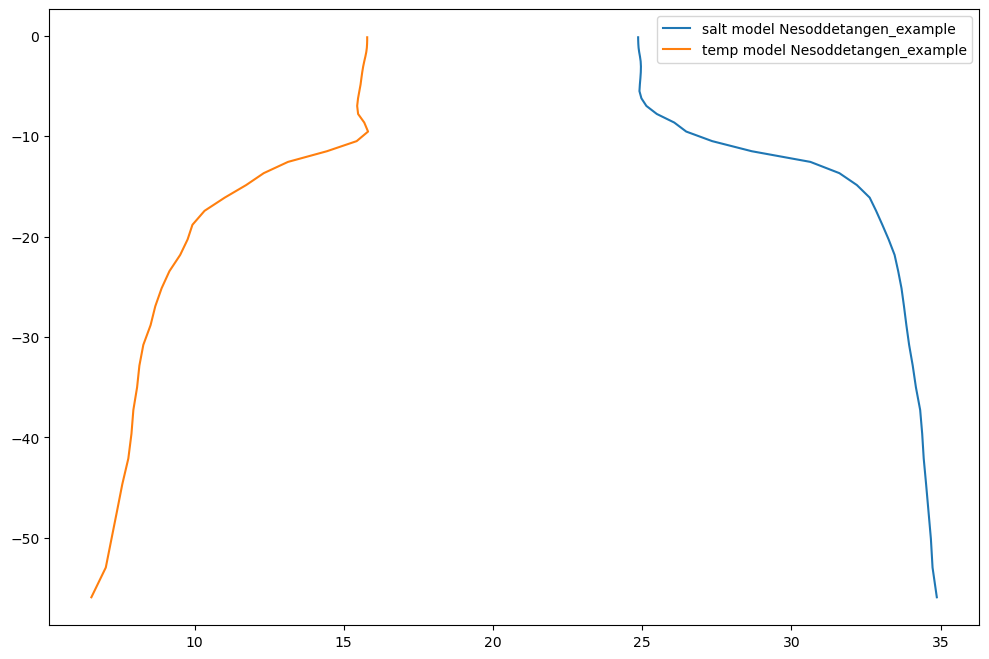

In [34]:
# Loop over all stations:
for i in range(len(name)):
    x, y = roms_latlon2xy(nc, lat[i], lon[i]) # find x and y indexes
    t    = np.where(netCDF4.num2date(nc.variables['ocean_time'][:], nc.variables['ocean_time'].units) == dates[i])[0][0] # find time index
    mask = nc.variables['mask_rho'][:]
    if mask[y,x] == 0:
        print('Position is on land, will find nearest wet gridpoint')
        y, x = BFS(y,x,mask)
    salt = nc.variables['salt'][t,:,y,x]
    temp = nc.variables['temp'][t,:,y,x]
    print('user defined lat: {}, lon: {}'.format(lat[i], lon[i]))
    print('model lat: {}, lon: {}'.format(nc.variables['lat_rho'][y,x], nc.variables['lon_rho'][y,x]))
    print('{}: {}, {} (x, y), salt: {}, temp: {}'.format(name[i], x, y, salt, temp))
    print('-------------------------')
    plt.plot(salt, z_rho[:,y,x], label='salt model {}'.format(name[i]))
    plt.plot(temp, z_rho[:,y,x], label='temp model {}'.format(name[i]))
plt.legend()
plt.show()